In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "namrahrehman" # username from the json file
os.environ['KAGGLE_KEY'] = "8b847c31995e7d7c26d89a5e5b41ef6e" # key from the json file

In [ ]:
!kaggle datasets download -d jessicali9530/stl10

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1493, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1447, in dataset_download_files
    self.download_file(response, outfile, quiet, not force)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1834, in download_file
    size = int(response.headers['Content-Length'])
  File "/usr/local/lib/python3.10/dist-packages/urllib3/_collections.py", line 258, in __getitem__
    val = self._container[key.lower()]
KeyError: 'content-length'


In [ ]:
!pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 43.6 MB/s eta 0:00:00


In [ ]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as DataLoader

from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import Callback

import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision import datasets
from torchvision.datasets import STL10
from tqdm.notebook import tqdm


from torch.optim import Adam

import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

import zipfile
from PIL import Image
import cv2

In [ ]:
print(torch.__version__, torchvision.__version__, pl.__version__)

2.1.0+cu118 0.16.0+cu118 2.1.0


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 2


In [ ]:
pl.seed_everything(96)

INFO:lightning_fabric.utilities.seed:Seed set to 96


96

In [ ]:
class DataAugTransform:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
augmentation_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("DATASET_PATH", "/content/drive/MyDrive")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "/content/drive/MyDrive/Models")

In [ ]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=DataAugTransform(augmentation_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=DataAugTransform(augmentation_transforms, n_views=2),
)

Files already downloaded and verified
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Global seed set to 96


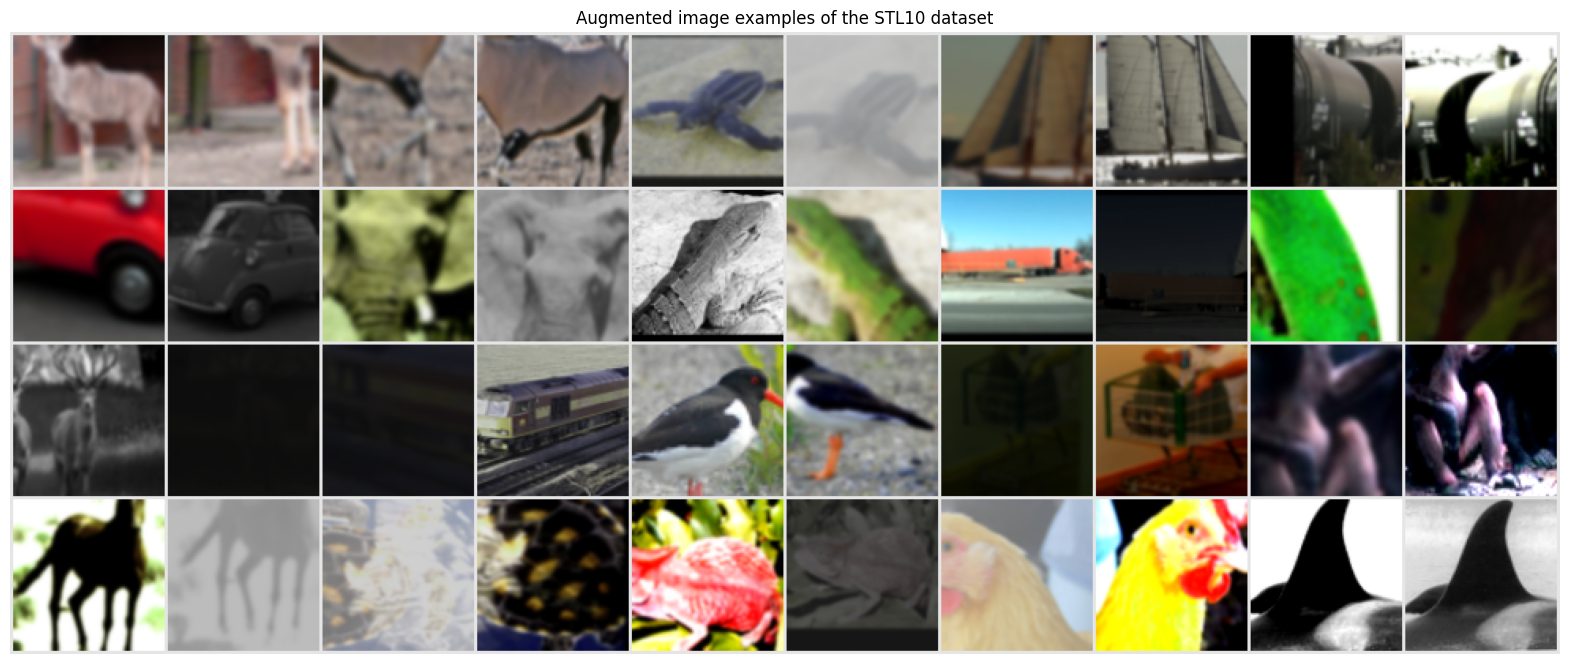

In [ ]:
# Visualize some examples
pl.seed_everything(96)
NUM_IMAGES = 20
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=10, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
#plt.close()

In [ ]:
class NTXentLoss(torch.nn.Module):

    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum").cuda()

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        return v

    def _cosine_simililarity(self, x, y):
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)
        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        print("Shape of l_pos:", l_pos.size())
        print("Shape of r_pos:", r_pos.size())
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)
        print("Shape of positives:",  positives.size())
        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)
        print("Shape of negatives:",  negatives.size())
        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [ ]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim, freeze=True):
        super(ResNetSimCLR, self).__init__()

        # Number of input features into the last linear layer
        num_ftrs = base_model.fc.in_features
        # Remove last layer of resnet
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        if freeze:
            self._freeze()

        # header projection MLP - for SimCLR
        self.l1 = nn.Linear(num_ftrs, 2*num_ftrs)
        self.l2_bn = nn.BatchNorm1d(2*num_ftrs)
        self.l2 = nn.Linear(2*num_ftrs, num_ftrs)
        self.l3_bn = nn.BatchNorm1d(num_ftrs)
        self.l3 = nn.Linear(num_ftrs, out_dim)

    def _freeze(self):
        num_layers = len(list(self.features.children())) # 9 layers, freeze all but last 2
        current_layer = 1
        for child in list(self.features.children()):
            if current_layer > num_layers-2:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False
            current_layer += 1

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        if len(h.shape) == 1:
            h = h.unsqueeze(0)

        x_l1 = self.l1(h)
        x = self.l2_bn(x_l1)
        x = F.selu(x)
        x = self.l2(x)
        x = self.l3_bn(x)
        x = F.selu(x)
        x = self.l3(x)
        return h, x_l1, x

In [ ]:
import yaml # Handles config file loading
# Load config file
config = '''
batch_size: 16
epochs: 9
weight_decay: 10e-6
out_dim: 256

dataset:
  s: 1
  input_shape: (96,96,3)
  num_workers: 4

optimizer:
  lr: 0.0001

loss:
  temperature: 0.05
  use_cosine_similarity: True

lr_schedule:
  max_lr: .1
  total_steps: 1500

model:
  out_dim: 128
  base_model: "resnet50"
'''
config = yaml.full_load(config)

In [ ]:
class simCLR(pl.LightningModule):

    def __init__(self, model, config, optimizer=Adam, loss=NTXentLoss):
        super(simCLR, self).__init__()
        # Config file (dictionary) to pass on parameters to each module: optimizer, loss, lr_schedule,
        self.config = config

        # Optimizer
        self.optimizer = optimizer

        # Model
        self.model = model

        # Loss
        self.loss = loss('cuda', self.config['batch_size'], **self.config['loss'])

    # Prediction/inference
    def forward(self, x):
        return self.model(x)

    # Sets up optimizer
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), **self.config['optimizer'])
        scheduler = OneCycleLR(optimizer, **self.config["lr_schedule"])
        return [optimizer], [scheduler]

    # Training loops
    def training_step(self, batch, batch_idx):
        x, y = batch
        xis, xjs = x
        ris, _, zis = self(xis)
        rjs, _, zjs = self(xjs)

        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)
        print("zis shape", zis.size())
        print("zjs shape",zjs.size())
        loss = self.loss(zis, zjs)
        return loss

    # Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        xis, xjs = x
        ris, _, zis = self(xis)
        rjs, _, zjs = self(xjs)

        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

        loss = self.loss(zis, zjs)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = None
        return loss

def _get_model_checkpoint():
    return ModelCheckpoint(
        filepath=os.path.join(os.getcwd(),"checkpoints","best_val_models"),
        save_top_k = 3,
        monitor="val_loss"
    )

In [ ]:
train_loader = DataLoader.DataLoader(
            unlabeled_data,
            batch_size=16,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
val_loader = DataLoader.DataLoader(
            train_data_contrast,
            batch_size=16,
            shuffle=False,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )

In [ ]:
print(len(unlabeled_data))

100000


In [ ]:
total_images = 0
total_batches = 0

for batch in train_loader:
    batch_size = len(batch)  # Get the number of items (views) in the batch
    total_images += batch_size
    total_batches += 1
    print(f"Batch {total_batches}: {batch_size} views")

print(f"Total images in the DataLoader: {total_images}")
print(f"Total batches in the DataLoader: {total_batches}")

Streaming output truncated to the last 5000 lines.
Batch 1253: 2 views
Batch 1254: 2 views
Batch 1255: 2 views
Batch 1256: 2 views
Batch 1257: 2 views
Batch 1258: 2 views
Batch 1259: 2 views
Batch 1260: 2 views
Batch 1261: 2 views
Batch 1262: 2 views
Batch 1263: 2 views
Batch 1264: 2 views
Batch 1265: 2 views
Batch 1266: 2 views
Batch 1267: 2 views
Batch 1268: 2 views
Batch 1269: 2 views
Batch 1270: 2 views
Batch 1271: 2 views
Batch 1272: 2 views
Batch 1273: 2 views
Batch 1274: 2 views
Batch 1275: 2 views
Batch 1276: 2 views
Batch 1277: 2 views
Batch 1278: 2 views
Batch 1279: 2 views
Batch 1280: 2 views
Batch 1281: 2 views
Batch 1282: 2 views
Batch 1283: 2 views
Batch 1284: 2 views
Batch 1285: 2 views
Batch 1286: 2 views
Batch 1287: 2 views
Batch 1288: 2 views
Batch 1289: 2 views
Batch 1290: 2 views
Batch 1291: 2 views
Batch 1292: 2 views
Batch 1293: 2 views
Batch 1294: 2 views
Batch 1295: 2 views
Batch 1296: 2 views
Batch 1297: 2 views
Batch 1298: 2 views
Batch 1299: 2 views
Batch 130

In [ ]:
resnet = models.resnet50(pretrained=True)

simclr_resnet = ResNetSimCLR(base_model=resnet, out_dim=config['out_dim'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.2MB/s]


In [ ]:
# Creates the simCLR model with the specified architecture from aboce
model = simCLR(config=config, model=simclr_resnet)

In [ ]:
# Initializes the model trainer
trainer = pl.Trainer(accelerator="gpu",
                     default_root_dir="/content/drive/MyDrive",
                     max_epochs=9,
                     devices="auto",
                     log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Fits the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | ResNetSimCLR | 40.8 M
1 | loss  | NTXentLoss   | 0     
---------------------------------------
32.3 M    Trainable params
8.5 M     Non-trainable params
40.8 M    Total params
163.313   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Shape of l_pos: torch.Size([16])
Shape of r_pos: torch.Size([16])
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])
Shape of l_pos: torch.Size([16])
Shape of r_pos: torch.Size([16])
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])


Training: |          | 0/? [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])
zis shape torch.Size([16, 256])
zjs shape torch.Size([16, 256])
Shape of l_pos: torch.Size([16])
Shape of r_pos: torch.Size([16])
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])
zis shape torch.Size([16, 256])
zjs shape torch.Size([16, 256])
Shape of l_pos: torch.Size([16])
Shape of r_pos: torch.Size([16])
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])
zis shape torch.Size([16, 256])
zjs shape torch.Size([16, 256])
Shape of l_pos: torch.Size([16])
Shape of r_pos: torch.Size([16])
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])
zis shape torch.Size([16, 256])
zjs shape torch.Size([16, 256])
Shape of l_pos: torch.Size([16])
Shape of r_pos: torch.Size([16])
Shape of positives: torch.Size([32, 1])
Shape of negatives: torch.Size([32, 30])
zis shape torch.Size([16

In [ ]:
# saving the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Models/weights_only_Resnet50.pth')
torch.save(model, '/content/drive/MyDrive/Models/entire_model_Resnet50.pth')